# Libraries

In [1]:
from dataclasses import dataclass
import time
import numpy as np
from transformers import pipeline
from src.engine.engine import Engine, EngineConfig
from src.ml.inference.master import MasterConfig, GenerationConfig
from pathlib import Path
from typing import List, Dict, Any, Tuple, Set, Callable
import matplotlib.pyplot as plt
from sentence_transformers import CrossEncoder

# Key metrics

In [2]:
@dataclass
class EvaluationMetrics:
    coherence: float
    context_relevance: float
    entity_consistency: float
    dnd_style: float
    response_time: float

# A class for comparative testing

In [3]:
class AugmentedLMComparator:
    def __init__(self, base_model_path: str, augmented_config: EngineConfig):
        self.base_model = pipeline(
            "text-generation", 
            model=base_model_path,
            tokenizer=base_model_path,
            device_map="auto"
        )
        self.augmented_engine = Engine(augmented_config)
        self.preambular = augmented_config.master_config.preambular.strip()
        self.cross_encoder = CrossEncoder('cross-encoder/stsb-roberta-large')
        self.classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
    
    def compare_responses(self, test_cases: List[Dict[str, str]]) -> Dict[str, List[Dict[str, float]]]:
        results = {"base": [], "augmented": []}
        
        for case in test_cases:
            prompt = case["prompt"]
            context = case.get("context", "")
            
            full_base_prompt = f"{self.preambular}\n\nContext: {context}\n\nPlayer: {prompt}\nDM:"
            base_time, base_response = self._time_execution(
                lambda: self.base_model(
                    full_base_prompt, 
                    max_new_tokens=128, 
                    temperature=0.7,
                    pad_token_id=self.base_model.tokenizer.eos_token_id
                )[0]['generated_text']
            )
            base_response = base_response.replace(full_base_prompt, "")
            
            augmented_time, augmented_response = self._time_execution(
                lambda: self.augmented_engine.dialog(statement=prompt))
            augmented_text = augmented_response.text
            
            base_metrics = self._evaluate_response(prompt, context, base_response)
            base_metrics["response_time"] = base_time
            
            augmented_metrics = self._evaluate_response(prompt, context, augmented_text)
            augmented_metrics["response_time"] = augmented_time
            
            results["base"].append(base_metrics)
            results["augmented"].append(augmented_metrics)
        
        return results
    
    def _time_execution(self, func: Callable) -> Tuple[float, Any]:
        start_time = time.time()
        result = func()
        return time.time() - start_time, result
    
    def _evaluate_response(self, prompt: str, context: str, response: str) -> Dict[str, float]:
        return {
            "coherence": self._calc_coherence(prompt, response),
            "context_relevance": self._calc_context_relevance(context, response),
            "entity_consistency": self._calc_entity_consistency(context, response),
            "dnd_style": self._calc_dnd_style(response)
        }
    
    def _calc_coherence(self, prompt: str, response: str) -> float:
        text = f"{prompt}\n{response}"
        result = self.classifier(
            text,
            candidate_labels=["coherent", "incoherent"],
            hypothesis_template="This response is {} to the prompt."
        )
        idx = result['labels'].index("coherent")
        return result['scores'][idx]
    
    def _calc_context_relevance(self, context: str, response: str) -> float:
        return self.cross_encoder.predict([(context, response)])[0]
    
    def _extract_entities(self, text: str) -> Set[Tuple[str, str]]:
        return {(e.text.strip().lower(), e.type) for e in self.augmented_engine.ner.extract(text)}

    def _calc_entity_consistency(self, context: str, response: str) -> float:
        context_entities = self._extract_entities(context)
        response_entities = self._extract_entities(response)

        if not context_entities:
            return 1.0

        consistent = sum(1 for ent in response_entities if ent in context_entities)
        return consistent / len(response_entities) if response_entities else 1.0
    
    def _calc_dnd_style(self, response: str) -> float:
        result = self.classifier(
            response,
            candidate_labels=["D&D fantasy", "modern", "sci-fi", "historical"],
            multi_label=True
        )
        for label, score in zip(result['labels'], result['scores']):
            if label == "D&D fantasy":
                return score
        return 0.0 
    
    def aggregate_results(self, results: Dict[str, List[Dict[str, float]]]) -> Dict[str, Dict[str, float]]:
        aggregated = {}
        for model_type in ["base", "augmented"]:
            model_results = results[model_type]
            aggregated[model_type] = {
                metric: np.mean([r.get(metric, 0) for r in model_results])
                for metric in model_results[0].keys()
            }
        return aggregated

In [4]:
preambular = """
The Tale of the Stolen Star  
*An introductory chronicle for the Dungeon Master*

By the flickering light of a guttering tavern candle, you prepare to weave a tale of shadows and stolen light. Before you sits Riley Quickfingers, a gutter-born rogue whose nimble fingers have plucked the Star of Luminis from the Syndicate's vault. 

### The Quickfingers Lad  
- Race: Moon-touched Human  
- Class: Whisperfoot Thief  
- Armaments:  
  • Lockpicks blessed by the Lockless God  
  • A silver dagger kissed by lunar smiths (crescent moon gleaming on its pommel)  
  • A shadow-weave cloak with pockets that drink the light  
  • A signet ring whispering dead men's names (cursed, though he knows it not)  
  • A pouch of stardust sand that glows like captured twilight  
- Cunning Arts: Phantom-step, lock-song, trap-sense, and fingers that dance like shadow-spiders  
- Sordid Past: Born in the filth-gutters of Hollow's End, Riley learned life's harsh truth - the wealthy build towers on bones. He steals, but holds to the Thieves' Creed: *"Never bleed the already bleeding."* His latest heist may have severed that last thread of honor...  

---

### Souls in the Shadows  

1. Booster "The Barrel" Durnan  
   - Station: Keeper of the Last Respite tavern, once Knife of the Shattered Hand guild  
   - Visage: A mountain of a man, shaved pate gleaming, beard like wrought iron. Jailhouse tales crawl across his arms in faded ink.  
   - Spirit: Gruff as a wyvern's cough, but fair-handed. Harbors old hatred for bullies and oathbreakers.  
   - Secret Heart: Guards more secrets than the Catacombs; knows why the Star was truly taken.  

2. Seraphine Duskwhisper  
   - Station: Star-seeker of the Silver Scroll Athenaeum  
   - Visage: Moon-pale elf with hair like frozen starlight, moving in a whisper of dark silk etched with arcane sigils.  
   - Spirit: Cool as grave-mist, words sharp as obsidian shards. Offers riddles when vexed.  
   - Secret Heart: Hired Riley to retrieve the Star, but spoke naught of the Void Hunger within it.  

3. Gristle the Snitch  
   - Station: Rat of the Shivering Market  
   - Visage: A twitchy half-elf skeleton with a wandering eye and nail-bitten fingers.  
   - Spirit: Jumpier than a goblin on coals, sweat-slick with perpetual fear.  
   - Secret Heart: Knows every whispered truth in Hollow's End - including who really owns Riley's cursed ring.  

---

### Foes in the Fog  

1. The Black Hand Syndicate  
   - Nature: Guild of Night's Embrace  
   - Garb: Shadow-leather armor, blood-scarves, blades like frozen screams  
   - Way of Blood: Strike from darkness with poisoned steel and cruel numbers  
   - Dark Purpose: Reclaim the Star... and silence the thief forever.  

2. The Hollow Specter  
   - Nature: Shade of the Forgotten Vow  
   - Visage: Smoke given malice, whispers given form  
   - Way of Blood: Walks through walls, drains life with ghost-touch  
   - Dark Purpose: Claim the ring... or claim the thief's soul as consolation.  

---

### Hollow's End: City of Whispers  
A crumbling port necropolis built upon older ruins, where marble towers pierce skies choked with the smoke of forges and funeral pyres. Below, in sewer and shadow, the forgotten scrape for crumbs. The Star of Luminis - relic of revelation - has been stolen, and now the underworld trembles like a spiderweb in a storm.  

---

### Places of Peril  

1. Booster’s Tavern  
   - A haven of ale and intrigue where light fears to tread. The scent of charred meat and betrayal hangs thick. Wanted posters flutter like trapped moths on walls that hide more than they reveal.  

2. The Shivering Market  
   - A thieves' bazaar where dreams are bartered. Smells of star-spice and blood-iron. Shadows here move with unnatural hunger.
3. The Syndicate’s Den  
   - A gilded trap of velvet and vice. Dice roll like skulls across tables rigged by demons. Scarlet-scarfed sentinels watch with serpent eyes.  

4. The Whispering Catacombs  
   - Subterranean labyrinth where skulls murmur forgotten secrets to those mad enough to listen.  

5. The Clocktower of Old Veyne  
   - A rusted sentinel where time bleeds. Gears grind with captured magic, air thick with ozone and prophecy.  

---

### Artifacts of Power & Peril
1. The Star of Luminis  
   - A crystal shard holding captured starlight. Reveals hidden truths when bathed in moonwash.  

2. The Onyx Ring of Mourning  
   - Silver band set with void-black stone. Whispers names of the damned at the witching hour.  

3. The Gauntlet of Shadow-Walk  
   - Obsidian-steel glove allowing brief passage through solid matter.  

4. The Tome of Eavesdropped Secrets  
   - Leather-bound book that inks itself with stolen whispers.  

5. The Ghost-Lantern  
   - Reveals the unseen... and attracts their hunger.  

6. The Dagger of Echoing Deaths  
   - Silent blade that sings the final screams of its victims.  

7. The Mask of Ten Thousand Faces  
   - Shapeshifter's boon... until the faces refuse to leave.  

---

### The Gathering Storm  
Riley thought the Star would be just another glittering prize. Now the Syndicate's knives seek his back, the Specter haunts his shadow, and Seraphine's eyes hold secrets colder than the grave. Booster’s Tavern offers scant sanctuary - trust here is coin spent quickly and bloodily.  

Will Riley unravel the Star's secret before Hollow's End becomes his tomb? The dice fall where they may...
"""

In [5]:
# model = AutoModel.from_pretrained("Qwen/Qwen3-1.7B")
# model.save_pretrained("models/base")
# tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-1.7B")
# tokenizer.save_pretrained("models/base")

In [6]:
config = EngineConfig(
    vector_db_path=Path('tmp/db'),
    number_of_remind_items=5,
    master_config=MasterConfig(
        path=Path('models/master'),
        preambular=preambular,
        generation_config=GenerationConfig(temperature=0.7, max_new_tokens=128),
    ),
    ner_model_path=Path('models/ner'),
    embedding_model_path=Path(
        'sentence-transformers/all-MiniLM-L6-v2'
    )
)

comparator = AugmentedLMComparator(
    base_model_path="models/base",
    augmented_config=config
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0
2025-06-19 19:39:21.431 | DEBUG    | src.engine.engine:__init__:29 - Loaded Master Model
Device set to use cuda:0
2025-06-19 19:39:21.561 | DEBUG    | src.engine.engine:__init__:32 - Loaded Ner Model: {'path': PosixPath('models/ner')}
2025-06-19 19:39:24.090 | DEBUG    | src.engine.engine:__init__:40 - Loaded Vector DB
2025-06-19 19:39:24.090 | DEBUG    | src.engine.engine:__init__:42 - Engine initialized
Device set to use cuda:0
Device set to use cuda:0


# Test dataset of D&D scenarios

In [7]:
DND_TEST_CASES = [
    {
        "context": "You sit hunched over a scarred oak table in Booster's Tavern, nursing an ale. "
                   "**Booster 'The Barrel' Durnan** polishes mugs behind the bar, his jailhouse tattoos rippling with each movement. "
                   "**Seraphine Duskwhisper** studies a pulsing crystal in the shadowed corner, its azure light casting dancing runes upon her elven features. "
                   "The air hangs thick with whispers of the stolen Star of Luminis and the Syndicate's wrath.",
        "prompt": "Lean across the bar and mutter to Booster: 'Heard the Black Hand's been sharpening their knives since the Star went missing. What trouble brews?'"
    },
    {
        "context": "The cursed signet ring grows cold upon your finger as moonlight filters through the grimy window of Seraphine's tower sanctum. "
                   "Ghostly whispers echo names of the dead - *'Alistair... Maris... Thorne...'* "
                   "**Seraphine Duskwhisper** traces arcane symbols in the air, her silver braids shimmering like captured starlight. "
                   "She warned the Hollow Specter has been seen coalescing near the Whispering Catacombs.",
        "prompt": "Place your ring-hand palm-up on her obsidian scrying table: 'This damned thing whispers louder each night. Can its curse be broken before the Specter claims my soul?'"
    },
    {
        "context": "You move like smoke through the Shivering Market, where stolen dreams are bartered under false moons. "
                   "The scent of dragon's pepper and bloodsteel fills the air as shadow-dealers hawk their ill-gotten wares. "
                   "**Gristle the Snitch** chews his nails near a stall selling bottled screams, his lazy eye darting nervously toward the Syndicate's Den entrance.",
        "prompt": "Press a silver dagger against Gristle's ribs in the lee of a silk merchant's stall: 'Speak true, weasel. Where will the Black Hand strike next? Your life for the truth.'"
    },
    {
        "context": "Ancient gears groan within the Clocktower of Old Veyne as Seraphine inscribes warding sigils with a staff of dragonbone. "
                   "The Star of Luminis thrums in your palm, its blue light revealing phantom writings on the tower walls - "
                   "*'Beware the Seventh Shadow'* pulses in eldritch script. Moonlight bleeds through cracked stained glass, painting the room in fractured colors.",
        "prompt": "Hold the Star aloft where moonbeams strike it: 'Can this relic reveal what's hidden behind the seventh gear? There are whispers of a vault...'"
    },
    {
        "context": "Rain lashes the cobblestones of Hollow's End as you crouch atop the Ragpicker's Roof. Below, "
                   "three Black Hand enforcers in blood-red scarves drag a screaming informant toward the Whispering Catacombs. "
                   "The cursed ring on your finger vibrates with dark energy, and for a moment, the shadows behind the thugs coalesce into the shape of the Hollow Specter.",
        "prompt": "Unsheathe your moon-etched dagger: 'Time to even the odds.' Roll stealth as you drop behind the lead enforcer."
    }
]

# Evaluation

In [8]:
results = comparator.compare_responses(DND_TEST_CASES)
aggregated = comparator.aggregate_results(results)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
2025-06-19 19:40:12.899 | DEBUG    | src.engine.engine:dialog:80 - Entities: [NerEntity(text='across', type=<NerEntityType.ACTION: 'ACTION'>), NerEntity(text='bar', type=<NerEntityType.ITEM: 'ITEM'>), NerEntity(text='mutter', type=<NerEntityType.ACTION: 'ACTION'>), NerEntity(text='booster', type=<NerEntityType.PER: 'PER'>), NerEntity(text='heard', type=<NerEntityType.ACTION: 'ACTION'>), NerEntity(text='hand', type=<NerEntityType.ITEM: 'ITEM'>), NerEntity(text='knives', type=<NerEntityType.ITEM: 'ITEM'>), NerEntity(text='went', type=<NerEntityType.ACTION: 'ACTION'>)]
2025-06-19 19:40:12.950 | DEBUG    | src.engine.engine:remind:51 - Remind Items: []
2025-06-19 19:40:12.962 | DEBUG    | src.engine.engine:remind:51 - Remind Items: []
2025-06-19 19:40:12.971 | DEBUG    | src.engine.engine:remind:51 - Remind Items: []
2025-06-19 19:40:12.985 | DEBUG   

In [9]:
print("\n" + "="*60)
print("Augmented D&D System Evaluation".center(60))
print("="*60)

metrics = ["coherence", "context_relevance", "entity_consistency", 
           "dnd_style", "response_time"]

print(f"{'Metric':<20} | {'Base LLM':<10} | {'Augmented':<10} | {'Delta':<8}")
for metric in metrics:
    base_val = aggregated["base"].get(metric, 0)
    aug_val = aggregated["augmented"].get(metric, 0)
    delta = aug_val - base_val
    
    print(f"{metric:<20} | {base_val:.4f}    | {aug_val:.4f}    | {delta:>+7.4f}")


              Augmented D&D System Evaluation               
Metric               | Base LLM   | Augmented  | Delta   
coherence            | 0.9307    | 0.9310    | +0.0003
context_relevance    | 0.2836    | 0.1322    | -0.1514
entity_consistency   | 0.0483    | 0.0525    | +0.0042
dnd_style            | 0.1488    | 0.0457    | -0.1031
response_time        | 36.2735    | 12.5796    | -23.6939


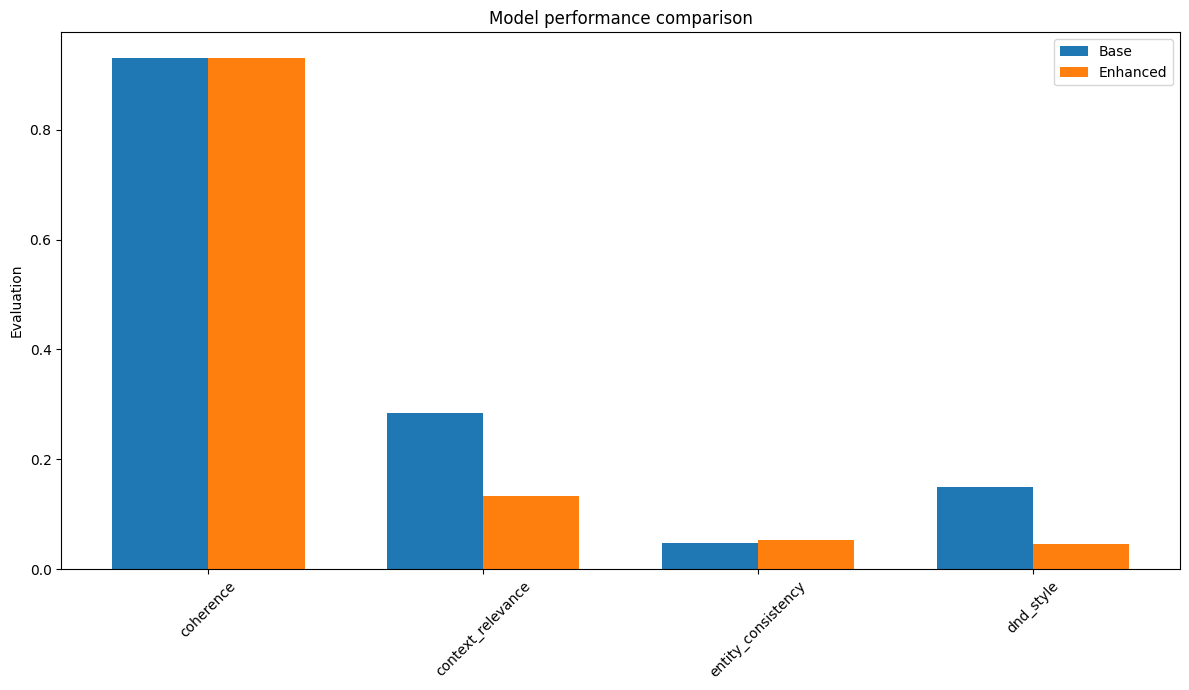

In [10]:
def plot_results(aggregated):
    metrics = [m for m in aggregated["base"].keys() if m != "response_time"]
    base_vals = [aggregated["base"][m] for m in metrics]
    enh_vals = [aggregated["augmented"][m] for m in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 7))
    rects1 = ax.bar(x - width/2, base_vals, width, label='Base')
    rects2 = ax.bar(x + width/2, enh_vals, width, label='Enhanced')
    
    ax.set_ylabel('Evaluation')
    ax.set_title('Model performance comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45)
    ax.legend()
    
    plt.tight_layout()
    plt.savefig("model_comparison.png")

plot_results(aggregated)